In [11]:
%load_ext autoreload 

from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from easydict import EasyDict as edict
import pandas as pd
import os
from collections import defaultdict
from joblib import Parallel, delayed
import multiprocessing as mp
from IPython.core.debugger import set_trace
from IPython.display import clear_output
import copy

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_swiss_roll,\
                             make_s_curve,\
                             make_moons

from umap import UMAP

import torch
from torch import nn
from torch import optim
from torch import autograd
from torch.utils.data import DataLoader

from train_utils import get_capacity, train, get_grad_params, criterion_rule
from metric_utils import calculate_Q_metrics,  to_numpy

from input_utils import DataGenerator, make_random_affine
from mlp_model import MLP_NonlinearEncoder
from models_utils import init_weights, \
                         universal_approximator, \
                         dJ_criterion, \
                         gained_function, \
                         sigmoid, \
                         initialize_nonlinearities

from embedding_utils import ConstructUMAPGraph, UMAPLoss, UMAPDataset, umap_criterion_compatibility

import pygad
from torchga import TorchGA, model2vector, vector2model

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 20
device = torch.device('cuda:0')
N_CPU = mp.cpu_count()
SEED = 42
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data 

In [12]:
SCALER = StandardScaler()

input_parameters = {'generator': make_s_curve, #make_s_curve, 
                    'generator_kwargs': {'n_samples':10000, 'noise':1e-2}, # 1e-1
                    'unsupervised':True,
                    'whiten':True,
                    'scaler':SCALER,
                    'use_outpt_color':True} 

create_data = DataGenerator(**input_parameters)

inpt, _, color = create_data()

N_TEST = 1000

In [13]:
inpt.mean(1), inpt.std(1)

(array([ 8.28226376e-18,  6.63405442e-16, -2.07861506e-17]),
 array([1., 1., 1.]))

In [14]:
inpt.max(1), inpt.min(1), inpt@inpt.T / inpt.shape[1]

(array([1.42704883, 1.74007636, 1.45825062]),
 array([-1.47028619, -1.76977241, -1.4751723 ]),
 array([[ 1.        ,  0.01899689, -0.10657352],
        [ 0.01899689,  1.        ,  0.00748955],
        [-0.10657352,  0.00748955,  1.        ]]))

In [15]:
inpt_train, inpt_test, color_train, color_test = train_test_split(inpt.T, 
                                                                  color, 
                                                                  random_state=42,
                                                                  test_size=N_TEST)

In [16]:
inpt_train_torch = torch.tensor(inpt_train, dtype=torch.float32).to(device)
inpt_test_torch = torch.tensor(inpt_test, dtype=torch.float32).to(device)

In [17]:
(inpt_train_torch.T@inpt_train_torch / inpt_train_torch.shape[0]).round()

tensor([[1., 0., -0.],
        [0., 1., 0.],
        [-0., 0., 1.]], device='cuda:0')

In [18]:
inpt_train_torch.mean(0), inpt_train_torch.std(0)

(tensor([-0.0017, -0.0002,  0.0009], device='cuda:0'),
 tensor([1.0003, 0.9981, 0.9996], device='cuda:0'))

In [19]:
inpt_train_torch.shape, inpt_test_torch.shape

(torch.Size([9000, 3]), torch.Size([1000, 3]))

In [28]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(inpt.T, columns=['x','y', 'z'])
# if color is not None:
#     df['target'] = color
# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target' if 'target' in df else None)

# fig.show()

# Metalearning: evolution

### Setup GA

In [44]:
LEARNING_TYPE = 'Criterion' 

encoder_parameters = {
                    'input_dim':inpt.shape[0],
                    'hidden_dim':10,
                    'embedding_dim':2,
                    'add_readout':False,
                    'hebbian_update':criterion_rule,
                    'inplace_update':False,
                    'normalize_hebbian_update':True,
                    'lr_hebb':1e-4,
                    'parametrized_f':True,
                    'W_requires_grad':False,
                    'f_requires_grad':True,
                    'final_nonlinearity':False,
                    'nonlinearity': universal_approximator,
                    'f_kwargs':{'hidden_dim':10, 'requires_grad':True},
                    'layers_number':2,
                    'add_bn':True,
                    'seed':None,
                    'set_seed':False,
                     }


training_parameters = edict({'epochs':10,
                           'enable_grad_train':False,
                           'enable_grad_val':False,
                           'maxiter':1000, # maxiter
                           'shuffle':True, # shuffle data
                           'progress_bar':True,
                           'weight_saver':None,
                           'calculate_grad':False,
                           'clip_grad_value': None,
                           'val_metrics':None,
                           'device':'cpu'
                          })

criterion_kwargs = defaultdict(dict)
criterion_kwargs['skip_train'] = True
criterion_kwargs['skip_val'] = True

network = MLP_NonlinearEncoder(**encoder_parameters).to(training_parameters['device'])

Net capacity: 260
Parameters:
W_s.0 torch.Size([10, 3]) requires_grad: False Device: cpu
W_s.1 torch.Size([2, 10]) requires_grad: False Device: cpu
f_s.0.theta1 torch.Size([10, 10]) requires_grad: True Device: cpu
f_s.0.bias1 torch.Size([10, 10]) requires_grad: True Device: cpu
f_s.0.theta2 torch.Size([1, 10]) requires_grad: True Device: cpu


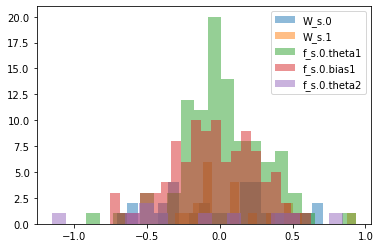

In [45]:
print('Net capacity:', get_capacity(network))
print('Parameters:')

for name, param in network.named_parameters():
    print(name, param.shape, 'requires_grad:', param.requires_grad, 'Device:', param.device)
    W = to_numpy(param.data)
    plt.hist(W.flatten(),bins=20, alpha=0.5, label=f'{name}')
plt.legend()
plt.show()

In [46]:
# state_dict = torch.load('./results/mlp_nonlinear/checkpoints/MLP_BP_hdim-10_lnum-2_Wgrad-1_fgrad-1_universal_approximator_bn-0')
# initialize_nonlinearities(network, state_dict)
# # network.load_state_dict(state_dict)

In [47]:
graph_constructor = ConstructUMAPGraph(metric='euclidean', 
                                        n_neighbors=15, 
                                        random_state=SEED)

# (epochs_per_sample, head, tail, weight) 
test_graph_data = graph_constructor(inpt_test)

BATCH_SIZE_BP = 10000

dataset_test = UMAPDataset(inpt_test, 
                           *test_graph_data, 
                           device=training_parameters['device'],
                           batch_size=BATCH_SIZE_BP)

criterion_umap = UMAPLoss(device=training_parameters['device'], 
                         min_dist=0.1,
                         negative_sample_rate=5,
                         edge_weight=None,
                         repulsion_strength=1.0)

criterion = umap_criterion_compatibility(criterion_umap)

Mon Jul 11 11:54:17 2022 Building RP forest with 7 trees
Mon Jul 11 11:54:17 2022 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	Stopping threshold met -- exiting after 2 iterations


In [48]:
for b in dataset_test:
    print(b.shape)

torch.Size([10000, 3])
torch.Size([10000, 3])
torch.Size([10000, 3])
torch.Size([10000, 3])
torch.Size([10000, 3])
torch.Size([10000, 3])
torch.Size([10000, 3])
torch.Size([10000, 3])
torch.Size([10000, 3])
torch.Size([10000, 3])
torch.Size([10000, 3])
torch.Size([10000, 3])


In [52]:
train_hebb_dataloader = DataLoader(inpt_train_torch.to(training_parameters['device']),
                                   batch_size=1, 
                                   shuffle=True,
                                   num_workers=N_CPU//2,
                                   persistent_workers=True)

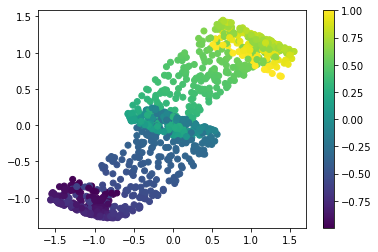

In [53]:
X_s = network.forward(inpt_test_torch.to(training_parameters['device']))
outpt_val_pred = to_numpy(X_s[-1])

plt.figure()
plt.scatter(outpt_val_pred[0],
            outpt_val_pred[1], 
            c=color_test
           )
plt.colorbar()
plt.show()

In [54]:
network.normalize_hebbian_update

True

### Hebbian training example

In [55]:
# # training connectivity using local rule
# network, _, metric_dict = train(network, 
#                                 opt=None, 
#                                 criterion=None,
#                                 criterion_kwargs=criterion_kwargs,
#                                 parameters=training_parameters,
#                                 train_dataloader=train_hebb_dataloader,
#                                 val_dataloader=None, 
#                                 metric_dict=None,
#                                 val_metrics=None
#                                 )

### Training GA

In [56]:
def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

def fitness_func(solution, sol_idx):
    
    global training_parameters, criterion_kwargs, network, inpt_train_torch
    
    # load proposed weight to model according to `filter_function`
    vector2model(network, solution, filter_function=get_grad_params)
    
    try:
        # training connectivity using local rule
        network, _, metric_dict = train(network, 
                                        opt=None, 
                                        criterion=None,
                                        criterion_kwargs=criterion_kwargs,
                                        parameters=training_parameters,
                                        train_dataloader=train_hebb_dataloader,
                                        val_dataloader=None, 
                                        metric_dict=None,
                                        val_metrics=None
                                        )
        
        # validation
        criterions_val = []
        for input_batch in dataset_test:
            output_batch = network.forward(input_batch)
            criterions_val.append(criterion(output_batch).item())

        criterions_val_mean = np.mean(criterions_val)

        solution_fitness = 1./(criterions_val_mean + 1e-3)
    
    except:
        # training failed
        solution_fitness = 0
    
    
#     outpt_val_pred = to_numpy(network(inpt_test_torch)[-1])
#     Q_loc_val_NET, Q_glob_val_NET = calculate_Q_metrics(inpt_test, outpt_val_pred.T)
#     solution_fitness = Q_loc_val_NET + Q_glob_val_NET
    
    return solution_fitness

In [57]:
# Create an instance of the pygad.torchga.TorchGA class to build the initial population.
torch_ga = TorchGA(model=network,
                   num_solutions=50,
                   filter_function=get_grad_params)
initial_population = torch_ga.population_weights # Initial population of network weights

In [58]:
num_generations = 10 # Number of generations.
num_parents_mating = 5 # Number of solutions to be selected as parents in the mating pool.

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation,
                       parallel_processing=None # N_CPU//2
                      ) 
ga_instance.run()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


Generation = 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.17it/s]


Fitness    = 3.532352100933667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


Generation = 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.31it/s]


Fitness    = 3.752643006716956


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


Generation = 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.31it/s]


Fitness    = 3.9061282042672123


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


Generation = 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


Fitness    = 3.881212708610829


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


Generation = 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.25it/s]


Fitness    = 3.881212708610829


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.20it/s]


Generation = 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]


Fitness    = 4.033077113426518


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]


Generation = 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


Fitness    = 4.043405773534246


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


Generation = 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.31it/s]


Fitness    = 4.053906260223126


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


Generation = 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


Fitness    = 4.053906260223126


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


Generation = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]

Fitness    = 4.053906260223126


In [1]:
ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)

NameError: name 'ga_instance' is not defined

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()

In [ ]:
vector2model(network, solution, filter_function=get_grad_params)

In [ ]:
outpt_val_pred = to_numpy(network(inpt_test_torch.to(training_parameters['device']))[-1])

plt.figure()
plt.scatter(outpt_val_pred[0],
            outpt_val_pred[1], 
            c=color_test
           )
plt.colorbar()
plt.show()